In [1]:
%load_ext jupyter_black

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot#define-evaluation

# Steps
1. Preprocessing: tokenization, sentence splitting, lower-case, `<SOS>` sentence `<EOS>`
2. sentences are in one text file, questions are in another text file
3. Vocab: most frequent 45k for sentence, most frequent 28k for questions
4. Pretrained Word Embedding: glove.840b.300d in the embedding layer

# Architecture Details
1. Both encoder & decoder has: Bidirectional LSTM, 2 Layers, 600 hidden dim 
2. SGD Optimizer
3. Initial LR 1.0, at epoch 8, LR 0.5
4. batch size 64
5. Dropout 0.3 between vertical LSTM stacks
6. Gradient Clipping when norm exceeds 5
7. Max epoch 15
8. Attention based encoding: the encoder produces hidden state from a bidirectional LSTM $h_t$ from input sequence $x$ where $t = 1...|x|$. Attention based encoding $c_t$ is the weighted average of all the hidden states, $h_i$ in that sentence.
9. The weight is an attention matrix of shape $(|x|, |x|)$. \
    Attention of i to t, $a_{i,t}$ is exponential of (i's hidden state $\times$ learnable parameter $\times$ t's hidden state) over sum of the above for all tokens to t. 

# Inference
1. Beam Size 3
2. Generate until `<EOS>` tag found

I ----------- $h_0$ \
am -----------$h_1$ \
human -------- $h_2$ \
android ------$h_3$ 

t = 2 \
encoding of `human` = attention `i` to `human` x `i` state \
               \+ attention `am` to `human` x `am` state

thus, encoding of a token is the weighted average of all the token's hidden state in the sentence.

# Import

In [2]:
from pathlib import Path
import io

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.translate import bleu

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from typing import List

# Look at Data
Data already preprocessed collected from the original repo.

In [3]:
data_root = Path("data/processed")

In [4]:
_n = 5
with open(data_root / "src-train.txt") as f:
    _sentences = [f.readline() for i in range(_n)]

with open(data_root / "tgt-train.txt") as f:
    _questions = [f.readline() for i in range(_n)]

for s, q in zip(_sentences, _questions):
    print(s)
    print()
    print(q)
    print("\n\n")

a pub / pʌb / , or public house is , despite its name , a private house , but is called a public house because it is licensed to sell alcohol to the general public . 


what is a pub licensed to sell ?




a pub / pʌb / , or public house is , despite its name , a private house , but is called a public house because it is licensed to sell alcohol to the general public . 


what is the term ` pub ' short for ?




the writings of samuel pepys describe the pub as the heart of england . 


who said that pubs are the heart of england ?




the history of pubs can be traced back to roman taverns , through the anglo-saxon alehouse to the development of the modern tied house system in the 19th century . 


how far back does the history of pubs go back ?




the history of pubs can be traced back to roman taverns , through the anglo-saxon alehouse to the development of the modern tied house system in the 19th century . 


what is a pub tied to in the 19th century ?






In [5]:
with open(data_root / "src-train.txt") as f:
    _sentences = f.readlines()

with open(data_root / "tgt-train.txt") as f:
    _questions = f.readlines()

print(len(_sentences), len(_questions))

70484 70484


# Vocabulary

In [6]:
import torchtext
from torchtext.vocab import build_vocab_from_iterator, GloVe

/home/riyadh/codes/nlp/learn2ask/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def yield_token(text_file_path):
    with io.open(text_file_path, encoding="utf-8") as f:
        for line in f:
            yield line.strip().split()

In [8]:
%%time
sentence_vocab = build_vocab_from_iterator(
    yield_token(data_root / "src-train.txt"),
    max_tokens=45000,
    specials=["<SOS>", "<EOS>", "<PAD>", "<UNK>"],
    special_first=True,
)

question_vocab = build_vocab_from_iterator(
    yield_token(data_root / "tgt-train.txt"), max_tokens=28000
)

CPU times: user 798 ms, sys: 81.3 ms, total: 879 ms
Wall time: 870 ms


In [9]:
# merge two vocabs once collected from separate corpus
vocab = torchtext.vocab.Vocab(sentence_vocab)
vocab.set_default_index(vocab["<UNK>"])

for token in question_vocab.get_itos():
    if token not in vocab:
        vocab.append_token(token)

print(len(vocab))

49823


In [10]:
embedding_vector = torch.zeros(size=(len(vocab), 300))
glove = GloVe(cache="data/")
for index in range(len(vocab)):
    embedding_vector[index] = glove[vocab.lookup_token(index)]

# Model

In [54]:
class EncoderDecoder(nn.Module):
    """
    encoder decoder model only handling a single sample
    """
    def __init__(self, vocab_size, embedding_vector, embedding_dim=300, hidden_dim=8, bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_vector)
        
        self.encoder = nn.LSTM(input_size=embedding_dim, 
                               hidden_size=hidden_dim,
                               batch_first=True,
                               bidirectional=bidirectional)

        # self.decoder = nn.LSTM(input_size=embedding_dim, 
        #                       hidden_size=hidden_dim, 
        #                       batch_first=True,
        #                       bidirectional=False)

        self.decoder_lstm_cell = nn.LSTMCell(input_size=embedding_dim,
                                             hidden_size=hidden_dim)

        self.attn_layer = nn.Linear(in_features=hidden_dim,
                                    out_features=hidden_dim)

        self.decoder_linear = nn.Sequential(nn.Linear(2*hidden_dim, 2*hidden_dim),
                                            nn.Tanh(),
                                           nn.Linear(2*hidden_dim, vocab_size))


    def forward(self, source, tgt):
        """
        Parameters
        ----------
        source: torch.Tensor. 
        """
        source = self.embedding(source)
        # b (N, L, d), hT & cT (1, N, d), hidden states from the last timestep
        b, (hT, cT) = self.encoder(source)
        logits = self.decoder(b, tgt)
        return logits


    def decoder(self, src_states, tgt):
        """
        Parameters
        ----------
        src_states: torch.Tensor (N, L, d)
        """
        MAX_LENGTH = len(tgt)
        # input
        next_token = torch.tensor(45000)
        logits = []
        t = 0
        
        while t in range(MAX_LENGTH):
            embeddings = self.embedding(next_token)
            ht, _ = self.decoder_lstm_cell(embeddings)
            at = self.attention(src_states, ht)
            # print(at.shape, src_states.shape)
            ct = (at.view(1, at.shape[0]) @ src_states).squeeze()
            decoder_input = torch.cat((ht, ct))
            logit = self.decoder_linear(decoder_input)
            logits.append(logit)
            next_token = tgt[t]
            t+=1

        return logits
    

    def attention(self, hs, ht):
        """
        Parameters
        ----------
        hs: (|x|, d)
        ht: (d,)

        Returns
        -------
        at: (|x|,)
        """
        # (|x|, d)
        attn = self.attn_layer(hs)
        # (1, d) (d, |x|) = (1, |x|)
        attn =  ht.T @ attn.T
        return attn.T / attn.T.sum(dim=0)
        
        

In [14]:
model = EncoderDecoder(len(vocab), embedding_vector)
logits =model(_src_indexed, _tgt_indexed)
print(len(logits))

3
3


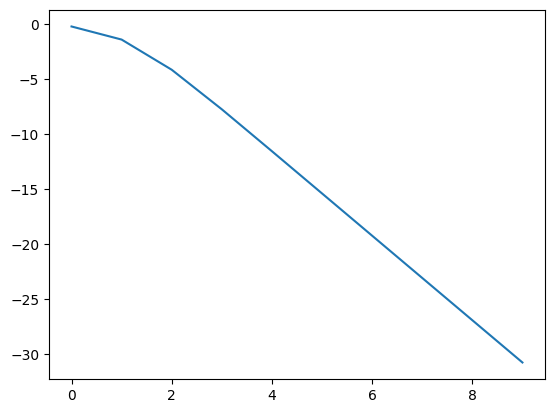

In [62]:
def train_epoch(model, optimizer):
    criterion = nn.NLLLoss()
    total_loss = 0
    for data in zip(_sentences, _questions):
        input_tensor = torch.tensor(vocab(data[0].split()), dtype=torch.long)
        _target = data[1].split()
        _target.append('<EOS>')
        target_tensor = torch.tensor(vocab(_target), dtype=torch.long)

        optimizer.zero_grad()

        logits = model(input_tensor, target_tensor)
        final_logits = torch.cat(logits).view(-1, logits[0].size()[0])
        # print(target_tensor.shape, final_logits.shape)

        loss = criterion(
            final_logits,
            target_tensor
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(_questions)

model = EncoderDecoder(len(vocab), embedding_vector)
optim = torch.optim.SGD(model.parameters(),lr = 1.0)

losses = []
for i in range(10):
    loss = train_epoch(model, optim)
    losses.append(loss)

plt.plot(losses)

In [49]:
_a = [torch.randn((10, )) for i in range(3)]

In [50]:
print(_a)
_a = torch.cat(_a).view(-1, 10)
print(_a)

[tensor([-1.0744, -0.3082,  0.8412, -0.7324, -0.6063, -0.0695, -0.0040,  1.6255,
        -1.4629,  0.3666]), tensor([-0.0700,  0.3958, -0.5411,  0.7852, -0.8056,  0.6153, -0.3385, -1.3658,
        -1.4265, -0.3672]), tensor([ 0.7445,  1.2010, -0.9885, -1.0478, -0.0517,  0.7053, -0.9229,  0.0703,
        -1.9221, -1.6314])]
tensor([[-1.0744, -0.3082,  0.8412, -0.7324, -0.6063, -0.0695, -0.0040,  1.6255,
         -1.4629,  0.3666],
        [-0.0700,  0.3958, -0.5411,  0.7852, -0.8056,  0.6153, -0.3385, -1.3658,
         -1.4265, -0.3672],
        [ 0.7445,  1.2010, -0.9885, -1.0478, -0.0517,  0.7053, -0.9229,  0.0703,
         -1.9221, -1.6314]])


# Batch Dataloader

In [12]:
config = {"sentence_max_length": 150, "question_max_length": 50, "batch_size": 32}

In [16]:
class SentenceQuestionDataset(Dataset):
    def __init__(
        self,
        vocab: torchtext.vocab.Vocab,
        sentences: List[str],
        questions: List[str],
        Ls=150,
        Lq=50,
    ):
        """
        Represents a dataset of text pairs for training or evaluating models that
        deal with relationships between text passages.

        Args:
            vocab (torchtext.vocab.Vocab): A pre-built vocabulary object
                containing word mappings from text to numerical representation.
            sentences (List[str]): A list of text passages (sentences, paragraphs, etc.).
            questions (List[str]): A list of corresponding questions related to the sentences.
            Ls (int, optional): The maximum length to which sentences will be
                truncated or padded during preprocessing (default: 150).
            Lq (int, optional): The maximum length to which questions will be
                truncated or padded during preprocessing (default: 50).
        """
        self.pad_index = vocab["<PAD>"]
        self.sos_index = vocab["<SOS>"]
        self.eos_index = vocab["<EOS>"]

        sentences_indexed = [vocab(document.split()) for document in sentences]
        questions_indexed = [vocab(document.split()) for document in questions]

        self.sentences_tensor = torch.full(
            (len(sentences), Ls), self.pad_index, dtype=torch.long
        )
        self.questions_tensor = torch.full(
            (len(questions), Lq), self.pad_index, dtype=torch.long
        )

        for i, data in enumerate(zip(sentences_indexed, questions_indexed)):
            # clip sentence length to Ls and add <sos>, <eos>

            _sentence_indices = (
                data[0] if len(data[0]) <= (Ls - 2) else data[0][: (Ls - 2)]
            )
            _sentence_indices = (
                [
                    self.sos_index,
                ]
                + _sentence_indices
                + [
                    self.eos_index,
                ]
            )
            ls = len(_sentence_indices)
            self.sentences_tensor[i, :ls] = torch.tensor(_sentence_indices)

            # clip question length to Lq and add <sos>, <eos>
            _question_indices = (
                data[1] if len(data[1]) <= (Lq - 2) else data[1][: (Lq - 2)]
            )
            _question_indices = (
                [
                    self.sos_index,
                ]
                + _question_indices
                + [
                    self.eos_index,
                ]
            )
            # lq may or may not be equal to Lq
            lq = len(_question_indices)
            self.questions_tensor[i, :lq] = torch.tensor(_question_indices)

    def __len__(self):
        return self.sentences_tensor.size(0)

    def __getitem__(self, index):
        return (self.sentences_tensor[index], self.questions_tensor[index])


train_ds = SentenceQuestionDataset(
    vocab,
    _sentences,
    _questions,
    Ls=config["sentence_max_length"],
    Lq=config["question_max_length"],
)

In [15]:
train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
print(len(train_dl))

2203


# Batched Model

In [35]:
class EncoderDecoder(nn.Module):
    """
    encoder decoder model only handling a single sample
    """

    def __init__(self, vocab_size, embedding_vector, hidden_dim=8, bidirectional=False):
        super().__init__()
        embedding_dim = embedding_vector.size(1)
        self.encoder = nn.Sequential(nn.Embedding.from_pretrained(embedding_vector),
                                     nn.LSTM(
                                        input_size=embedding_dim,
                                        hidden_size=hidden_dim,
                                        batch_first=True,
                                        bidirectional=bidirectional,
                                        ))

        self.decoder_lstm_cell = nn.LSTMCell(
            input_size=embedding_dim, hidden_size=hidden_dim
        )

        self.attn_layer = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)

        self.decoder_linear = nn.Sequential(
            nn.Linear(2 * hidden_dim, 2 * hidden_dim),
            nn.Tanh(),
            nn.Linear(2 * hidden_dim, vocab_size),
        )

    def forward(self, src: torch.Tensor, tgt: torch.Tensor):
        """
        Args:
            src (torch.Tensor): (N, Ls) A batch of source sentences represented as tensors.
            tgt (torch.Tensor): (N, Lq) A batch of target questions represented as tensors.
        """
        self.train()
        # encoder_representation (N, Ls, d), hT => cT => (#direction * #layer, N, d) : hidden states from the last timestep
        encoder_repr, (hT, cT) = self.encoder(src)

        # (N, Lq, vocab_size)
        logits = self.decoder(encoder_repr, tgt, hT, cT)
        return logits

    def decoder(self, encoder_repr, tgt, hidden_state, cell_state, teacher_forcing=True):
        hidden_state = hidden_state.squeeze()
        cell_state = cell_state.squeeze()
        MAX_LENGTH = tgt.size(1)
        logits = []
        if not teacher_forcing:
            tgt = torch.full((encoder_repr.size(0), MAX_LENGTH), self.sos_index)
        
        for t in range(MAX_LENGTH):
            # => (N,)
            next_token = tgt[:, t]
            # => (N, embedding_dim)
            embeddings = self.embedding(next_token)
            # both => (N, d)
            hidden_state, cell_state = self.decoder_lstm_cell(
                embeddings, (hidden_state, cell_state)
            )
            # => (N, Ls)
            attn = self.attention(encoder_repr, hidden_state)
            # (N, 1, Ls) . (N, Ls, d) => (N, d)
            attn_based_ctx = torch.bmm(attn.unsqueeze(dim=1), encoder_repr).squeeze()
            # => (N, d*2)
            decoder_input = torch.cat((hidden_state, attn_based_ctx), dim=1)
            # => (N, vocab_size)
            logit = self.decoder_linear(decoder_input)
            logits.append(logit)

            # append the most probable token to tgt
            if not teacher_forcing:
                tgt[]

        return logits

    def attention(self, encoder_repr, decoder_hidden_state):
        """
        Args:
            encoder_repr (torch.Tensor): Encoder hidden states of shape (N, Ls, d).
            decoder_hidden_state (torch.Tensor): Decoder hidden state at timestep t of shape (N, d)
        """

        # => (N, Ls, d)
        attn = self.attn_layer(encoder_repr)
        # (N, d) (N, d, Ls) = (N, Ls)
        attn = decoder_hidden_state.unsqueeze(dim=1) @ attn.transpose(1, 2)
        attn = attn.squeeze()
        return attn / attn.sum(dim=1).unsqueeze(dim=1)


    def gen_greedy(self, src, max_seq_len=15):
        """
        greedy generation from the encoder-decoder model

        Args:
            src (torch.Tensor): (N, Ls) A batch of source sentences represented as tensors.

        Returns:
            a list of N sentences generated.
        """
        self.eval()
        with torch.no_grad():
            encoder_repr
            
        

SyntaxError: invalid syntax (1215024122.py, line 9)

In [ ]:
top_

  0%|▎                                                                                                                       | 6/2203 [00:14<1:27:27,  2.39s/batch, loss=3.61]


epoch 1 loss 0.020464931462929024


  0%|▎                                                                                                                       | 6/2203 [00:14<1:25:34,  2.34s/batch, loss=3.29]


epoch 2 loss 0.010557374573273383


  0%|▎                                                                                                                       | 6/2203 [00:13<1:25:15,  2.33s/batch, loss=3.25]


epoch 3 loss 0.010748619931533128


  0%|▎                                                                                                                       | 6/2203 [00:13<1:24:54,  2.32s/batch, loss=3.24]


epoch 4 loss 0.010627424181238175


  0%|▎                                                                                                                       | 6/2203 [00:13<1:24:11,  2.30s/batch, loss=3.03]


epoch 5 loss 0.01012355827819852


  0%|▎                                                                                                                       | 6/2203 [00:14<1:26:18,  2.36s/batch, loss=2.85]


epoch 6 loss 0.009776115525704971


  0%|▎                                                                                                                       | 6/2203 [00:14<1:25:26,  2.33s/batch, loss=2.88]


epoch 7 loss 0.00943056280592383


  0%|▎                                                                                                                       | 6/2203 [00:14<1:27:20,  2.39s/batch, loss=3.01]


epoch 8 loss 0.009521188272761043


  0%|▎                                                                                                                        | 6/2203 [00:14<1:26:17,  2.36s/batch, loss=2.9]


epoch 9 loss 0.008976691103609269


  0%|▎                                                                                                                       | 6/2203 [00:14<1:30:07,  2.46s/batch, loss=2.79]

epoch 10 loss 0.008659283680857392


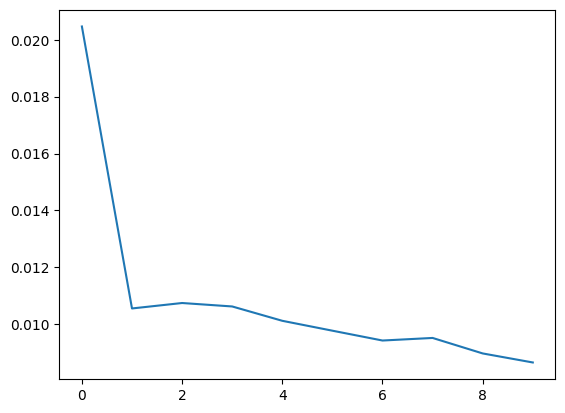

In [32]:
def train_epoch(model, optimizer, max_step=float("inf")):
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    bar = tqdm(train_dl, unit="batch")

    for step, data in enumerate(bar):
        optimizer.zero_grad()

        logits = model(data[0], data[1])
        final_logits = torch.cat(logits, dim=0).view(
            logits[0].size(0), -1, logits[0].size(1)
        )
        loss = criterion(final_logits.transpose(1, 2), data[1])
        bar.set_postfix(**{"loss": loss.item()})

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # early exit, needed during development
        if step > max_step:
            break

    return total_loss / len(train_dl)


model = EncoderDecoder(len(vocab), embedding_vector, hidden_dim=4)
optim = torch.optim.SGD(model.parameters(), lr=1.0)

losses = []
for i in range(1, 3):
    loss = train_epoch(model, optim, max_step=5)
    print("epoch", i, "loss", loss)
    losses.append(loss)

plt.plot(losses)

In [66]:
len(train_dl)

2